<a href="https://colab.research.google.com/github/vigneshm1995/BDIA-Project/blob/master/GAN%20Training%20Notebooks/Uninfected_Images_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training GANs on uninfected cell images

Download dataset and create necessary directories.

In [0]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
!mkdir generated_images
!mkdir generated_test_images
!mkdir gen_imgs
!mkdir saved_models


--2019-04-20 21:58:03--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  80.6MB/s    in 3.7s    

2019-04-20 21:58:07 (91.6 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



Unzip images

In [0]:
import zipfile
path_to_zip_file = "cell_images.zip"
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall()

In [0]:
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
import tensorflow as tf
from keras.optimizers import Adam
from PIL import Image
import numpy as np
from tqdm import tqdm

Using TensorFlow backend.


Removing db files because they cannot be processed as images.

In [0]:
!rm cell_images/Parasitized/Thumbs.db
!rm cell_images/Uninfected/Thumbs.db

rm: cannot remove 'cell_images/Parasitized/Thumbs.db': No such file or directory
rm: cannot remove 'cell_images/Uninfected/Thumbs.db': No such file or directory


## Viewing training data

In [0]:
import os
import random
import matplotlib.pyplot as plt
input_directory = "cell_images"
output_directory = r"../output/"

training_dir = input_directory
# testing_dir = input_directory + r"test"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [0]:


def plot_image(file, directory=None, sub=False, aspect=None):
    path = directory + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory=training_dir, count=5):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_dir_main(directory=training_dir, count=5):
    labels = os.listdir(directory)
    for label in labels:
        print(label)
        plot_img_dir(directory=directory+"/"+label+"/", count=count)
        



Parasitized


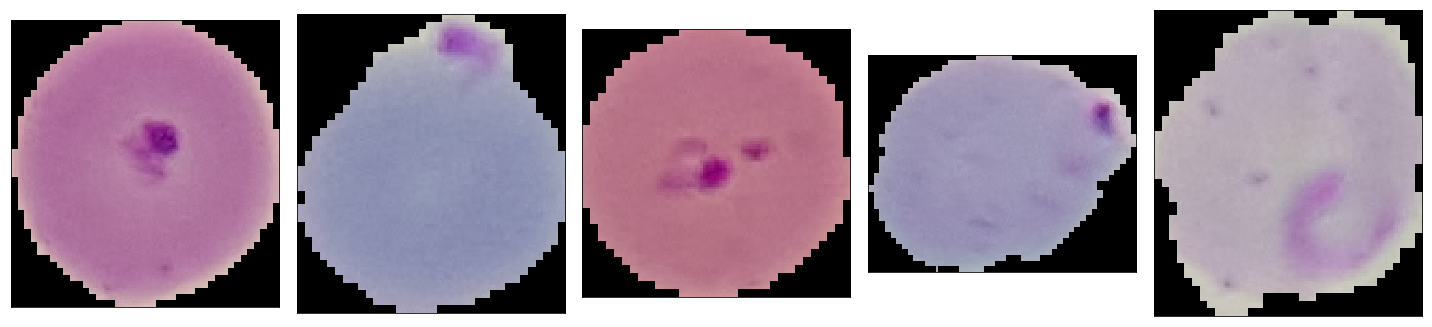

Uninfected


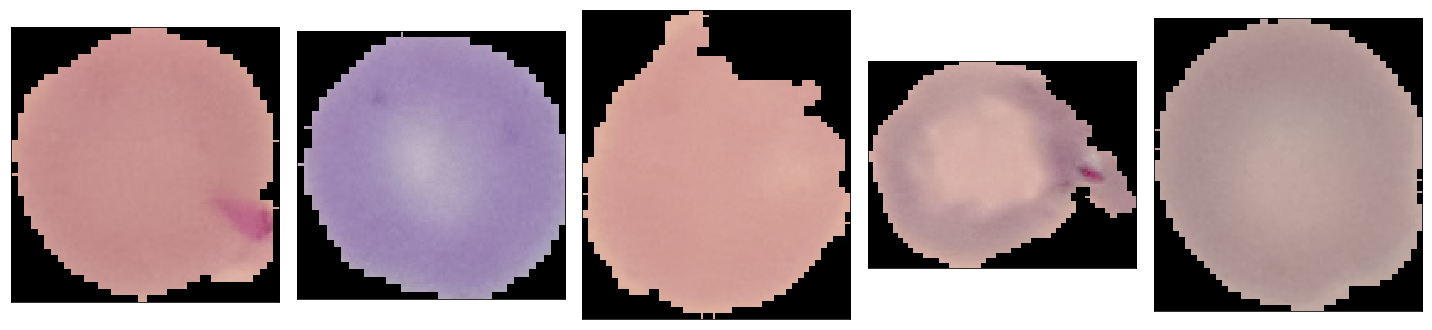

In [0]:
plot_img_dir_main(directory=training_dir, count=5)

## Building dataset

Images are converted to pixels and stored in an array of pixel data which is then used as input to the GAN.

In [0]:
def get_training_data(datafolder):
        print("Loading training data...")

        training_data = []
        #Finds all files in datafolder
        filenames = os.listdir(datafolder)
        for filename in tqdm(filenames):
            #Combines folder name and file name.
            path = os.path.join(datafolder,filename)
            #Opens an image as an Image object.
            image = Image.open(path)
            #Resizes to a desired size.
            image = image.resize((image_width,image_height),Image.ANTIALIAS)
            #Creates an array of pixel values from the image.
            pixel_array = np.asarray(image)

            training_data.append(pixel_array)

        #training_data is converted to a numpy array
        training_data = np.reshape(training_data,(-1,image_width,image_height,channels))
        return training_data

# Creating GAN [Generator and Discriminator]

- Generator takes random values as an input and produces an image.
- Discriminator  attempts to determine whether an image is fake or real.

Some notes to remember:
- Padding = 'same' means that output size in convolution layer remains same as input size.
- Batch normalization normalizes the output of each layer to combat internal covariate shift.
- Upsampling resizes the image back to its original state, the sole purpose of up sampling layers is to reduce computations in each layer, while keeping the dimension of input/output as before.
- We reshape after input layer of generator because CNNs require input in the shape.
- We are using the Model functional API since we are using multiple sequential models (i.e. Generator & Discriminator have intertwined data exchange).
- Kernel size: Size of convolutional filter
- Stride: Number of steps the filter takes across the pixel matrix.

In [0]:
    def build_generator():
        #Generator attempts to fool discriminator by generating new images.
        model = Sequential()

        model.add(Dense(256*4*4,activation="relu",input_dim=random_noise_dimension))
        model.add(Reshape((4,4,256)))

        #Four layers of upsampling, convolution, batch normalization and activation.
        # 1. Upsampling: Input data is repeated. Default is (2,2). In that case a 4x4x256 array becomes an 8x8x256 array.
        # 2. Convolution: If you are not familiar, you should watch this video: https://www.youtube.com/watch?v=FTr3n7uBIuE
        # 3. Normalization normalizes outputs from convolution.
        # 4. Relu activation:  f(x) = max(0,x). If x < 0, then f(x) = 0.


        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))


        # Last convolutional layer outputs as many featuremaps as channels in the final image.
        model.add(Conv2D(channels,kernel_size=3,padding="same"))
        # tanh maps everything to a range between -1 and 1.
        model.add(Activation("tanh"))

        # show the summary of the model architecture
        model.summary()

        # Placeholder for the random noise input
        input = Input(shape=(random_noise_dimension,))
        #Model output
        generated_image = model(input)

        #Change the model type from Sequential to Model (functional API) More at: https://keras.io/models/model/.
        return Model(input,generated_image)


    def build_discriminator():
        #Discriminator attempts to classify real and generated images
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
        #Leaky relu is similar to usual relu. If x < 0 then f(x) = x * alpha, otherwise f(x) = x.
        model.add(LeakyReLU(alpha=0.2))

        #Dropout blocks some connections randomly. This help the model to generalize better.
        #0.25 means that every connection has a 25% chance of being blocked.
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        #Zero padding adds additional rows and columns to the image. Those rows and columns are made of zeros.
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        #Flatten layer flattens the output of the previous layer to a single dimension.
        model.add(Flatten())
        #Outputs a value between 0 and 1 that predicts whether image is real or generated. 0 = generated, 1 = real.
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        input_image = Input(shape=image_shape)

        #Model output given an image.
        validity = model(input_image)

        return Model(input_image, validity)

### Training workflow:
- Normalize pixel values
- Set labels for real & generated [0 & 1] for the discriminator to identify images.
- Select random batch of images.
- Create random noise input based on batch size.
- Generator generates images using random noise input.
- Train discriminator on real images & on fake images so it can tell the difference.
- Generator is trained on combined model with feedback from discriminator to improve quality.
- Model is saved

In [0]:
def train(datafolder ,epochs,batch_size,save_images_interval):
        #Get the real images
        training_data = get_training_data(datafolder)

        #Map all values to a range between -1 and 1.
        training_data = training_data / 127.5 - 1.

        #Two arrays of labels. Labels for real images: [1,1,1 ... 1,1,1], labels for generated images: [0,0,0 ... 0,0,0]
        labels_for_real_images = np.ones((batch_size,1))
        labels_for_generated_images = np.zeros((batch_size,1))

        for epoch in range(epochs):
            # Select a random half of images
            indices = np.random.randint(0,training_data.shape[0],batch_size)
            real_images = training_data[indices]

            #Generate random noise for a whole batch.
            random_noise = np.random.normal(0,1,(batch_size,random_noise_dimension))
            #Generate a batch of new images.
            generated_images = generator.predict(random_noise)

            #Train the discriminator on real images.
            discriminator_loss_real = discriminator.train_on_batch(real_images,labels_for_real_images)
            #Train the discriminator on generated images.
            discriminator_loss_generated = discriminator.train_on_batch(generated_images,labels_for_generated_images)
            #Calculate the average discriminator loss.
            discriminator_loss = 0.5 * np.add(discriminator_loss_real,discriminator_loss_generated)

            #Train the generator using the combined model. Generator tries to trick discriminator into mistaking generated images as real.
            generator_loss = combined.train_on_batch(random_noise,labels_for_real_images)
            print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, discriminator_loss[0], 100*discriminator_loss[1], generator_loss))

            if epoch % save_images_interval == 0:
                save_images(epoch)
        generator.save("saved_models/saved_model1.h5")

        #Save the model for a later use


In [0]:
   def save_images(epoch):
        #Save 25 generated images for demonstration purposes using matplotlib.pyplot.
        rows, columns = 5, 5
        noise = np.random.normal(0, 1, (rows * columns, random_noise_dimension))
        generated_images = generator.predict(noise)

        generated_images = 0.5 * generated_images + 0.5

        figure, axis = plt.subplots(rows, columns)
        image_count = 0
        for row in range(rows):
            for column in range(columns):
                axis[row,column].imshow(generated_images[image_count, :], cmap='spring')
                axis[row,column].axis('off')
                image_count += 1
        figure.savefig("generated_images/generated_%d.png" % epoch)
        plt.close()

In [0]:

def generate_single_image(model_path,image_save_path):
        noise = np.random.normal(0,1,(1,random_noise_dimension))
        model = load_model(model_path)
        generated_image = model.predict(noise)
        #Normalized (-1 to 1) pixel values to the real (0 to 256) pixel values.
        generated_image = (generated_image+1)*127.5
        print(generated_image)
        #Drop the batch dimension. From (1,w,h,c) to (w,h,c)
        generated_image = np.reshape(generated_image,image_shape)

        image = Image.fromarray(generated_image,"RGB")
        image.save(image_save_path)

In [0]:
image_width = 64
image_height = 64
channels = 3

image_shape = (image_width,image_height,channels)

#Amount of randomly generated numbers for the first layer of the generator.
random_noise_dimension = 100

#Just 10 times higher learning rate would result in generator loss being stuck at 0.
optimizer = Adam(0.0002,0.5)

discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
generator = build_generator()

#A placeholder for the generator input.
random_input = Input(shape=(random_noise_dimension,))

#Generator generates images from random noise.
generated_image = generator(random_input)

# For the combined model we will only train the generator
discriminator.trainable = False

#Discriminator attempts to determine if image is real or generated
validity = discriminator(generated_image)

#Combined model = generator and discriminator combined.
#1. Takes random noise as an input.
#2. Generates an image.
#3. Attempts to determine if image is real or generated.
combined = Model(random_input,validity)
combined.compile(loss="binary_crossentropy",optimizer=optimizer)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_1

Loading uninfected cell images, running for 15000 epochs, we save our results at an interval of 1000.

In [0]:
train(datafolder="cell_images/Uninfected",epochs=15000, batch_size=32, save_images_interval=1000)
generate_single_image("saved_models/saved_model1.h5","gen_imgs/test.png")

  0%|          | 0/13779 [00:00<?, ?it/s]

Loading training data...


100%|██████████| 13779/13779 [00:24<00:00, 561.09it/s]


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [Discriminator loss: 2.083358, acc.: 39.06%] [Generator loss: 0.420421]
1 [Discriminator loss: 0.492972, acc.: 71.88%] [Generator loss: 3.162010]
2 [Discriminator loss: 0.138810, acc.: 95.31%] [Generator loss: 3.229404]
3 [Discriminator loss: 0.097205, acc.: 96.88%] [Generator loss: 1.216566]
4 [Discriminator loss: 0.111012, acc.: 95.31%] [Generator loss: 1.563010]
5 [Discriminator loss: 0.060803, acc.: 100.00%] [Generator loss: 2.268231]
6 [Discriminator loss: 0.095287, acc.: 96.88%] [Generator loss: 2.181068]
7 [Discriminator loss: 0.111898, acc.: 98.44%] [Generator loss: 2.291213]
8 [Discriminator loss: 0.084670, acc.: 98.44%] [Generator loss: 3.900319]
9 [Discriminator loss: 0.101647, acc.: 100.00%] [Generator loss: 3.849986]
10 [Discriminator loss: 0.214010, acc.: 92.19%] [Generator loss: 5.972817]
11 [Discriminator loss: 0.104584, acc.: 96.88%] [Generator loss: 4.171814]
12 [Discriminator loss: 0.143546, acc.: 96.88%] [Generator loss: 4.269965]
13 [Discriminator loss: 0.201277,

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


## Viewing our results

In [0]:

def plot_test_image(file, directory=None, sub=False, aspect=None):
    path = directory +'/'+ file
    
    img = plt.imread(path)
    
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
def plot_test_img_dir(directory=training_dir, count=5):
    selected_files = os.listdir(directory)
    print(sorted(selected_files))
    ncols = 1
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(500, 5*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in sorted(selected_files):        
        plt.subplot(nrows, ncols, i+1)
        path = directory +'/'+ file
        
        plot_test_image(file, directory, aspect=None)

        i=i+1
    
    #plt.tight_layout()
    plt.show()

We can see the evolution of the quality of our synthetic images here.

['generated_0.png', 'generated_1000.png', 'generated_10000.png', 'generated_11000.png', 'generated_12000.png', 'generated_13000.png', 'generated_14000.png', 'generated_2000.png', 'generated_3000.png', 'generated_4000.png', 'generated_5000.png', 'generated_6000.png', 'generated_7000.png', 'generated_8000.png', 'generated_9000.png']


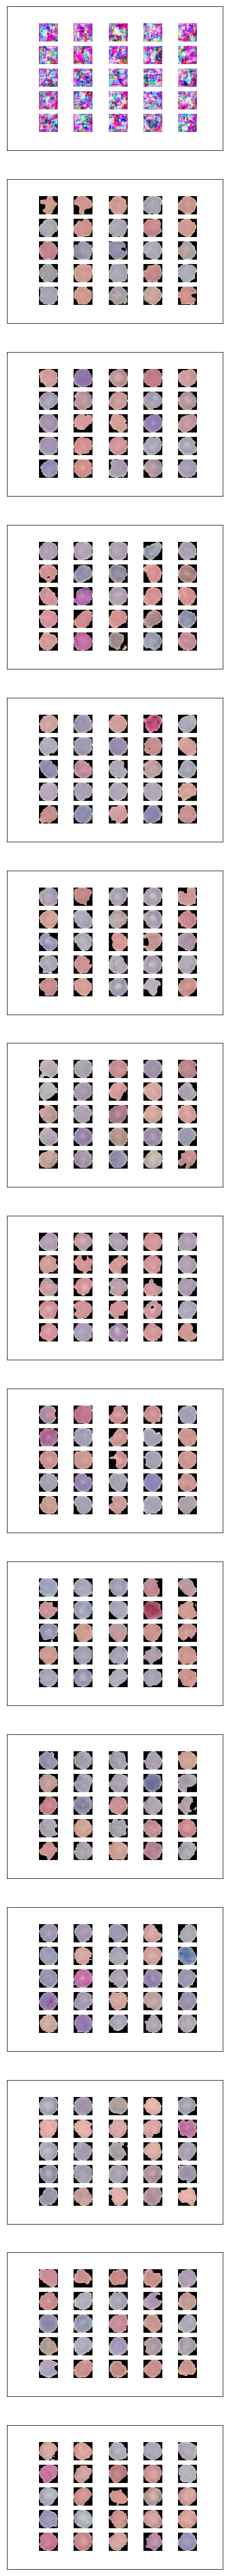

In [0]:
plot_test_img_dir(directory="generated_images", count=15)

## Generate test set from trained GAN

In [0]:
from keras.models import load_model
from keras import backend as K

In [0]:
saved_model_path = 'saved_models/saved_model1.h5'
generator = load_model(saved_model_path)
def save_test_images_one(epoch,generator):
        #Save each generated image 
        rows, columns = 2, 2
        noise = np.random.normal(0, 1, (rows * columns, random_noise_dimension))
        
        
        generated_images = generator.predict(noise)

        generated_images = 0.5 * generated_images + 0.5

        figure, axis = plt.subplots()
        image_count = 0
        
        axis.imshow(generated_images[1, :], cmap='spring')
        axis.axis('off')
        figure.savefig("generated_test_images/generated_%d.png" % epoch)
        plt.close()


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


We will generate 1,000 synthetic images which we will later use for testing.

In [0]:
for i in range(0,1000):
  save_test_images_one(i,generator)
  print("Saved image "+str(i))

Saved image 0
Saved image 1
Saved image 2
Saved image 3
Saved image 4
Saved image 5
Saved image 6
Saved image 7
Saved image 8
Saved image 9
Saved image 10
Saved image 11
Saved image 12
Saved image 13
Saved image 14
Saved image 15
Saved image 16
Saved image 17
Saved image 18
Saved image 19
Saved image 20
Saved image 21
Saved image 22
Saved image 23
Saved image 24
Saved image 25
Saved image 26
Saved image 27
Saved image 28
Saved image 29
Saved image 30
Saved image 31
Saved image 32
Saved image 33
Saved image 34
Saved image 35
Saved image 36
Saved image 37
Saved image 38
Saved image 39
Saved image 40
Saved image 41
Saved image 42
Saved image 43
Saved image 44
Saved image 45
Saved image 46
Saved image 47
Saved image 48
Saved image 49
Saved image 50
Saved image 51
Saved image 52
Saved image 53
Saved image 54
Saved image 55
Saved image 56
Saved image 57
Saved image 58
Saved image 59
Saved image 60
Saved image 61
Saved image 62
Saved image 63
Saved image 64
Saved image 65
Saved image 66
Saved

## Export saved images to zip to use later for testing CNN model

In [0]:
import shutil
shutil.make_archive('uninfected_1k.zip', 'zip', 'generated_test_images')

'/content/uninfected_1k.zip.zip'

## References

Code for building GANs was adapted from here: https://medium.com/datadriveninvestor/generating-human-faces-with-keras-3ccd54c17f16

## License
Copyright(c) 2019 Vignesh Murali, Rajeshree Kale, Rishi Rajani

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.